# Inclusive Speech Technology Lab - Week 2

## Acoustic Features for Inclusive Speech Processing

**The goal of this lab is to reflect on what kind of information is included in speech and what kind of acoustic features capture task-specific information. In other words, which acoustic feature(s) is best for what speech processing task and link this to speech as a communication signal.** In this lab you will learn about various acoustic features. First, you will extract different acoustic features from speech files. Throughout this lab, you will be using two databases, the German emotions dataset [Emo-DB](https://github.com/audeering/emodb), and the [Delft Database of EEG Recordings of Dutch Articulated and Imagined Speech (DAIS)](https://pure.tudelft.nl/ws/portalfiles/portal/157666992/DAIS_The_Delft_Database_of_EEG_Recordings_of_Dutch_Articulated_and_Imagined_Speech.pdf) dataset. You will extract features from each dataset, and cluster them using k-means clustering, with the goal of finding clusters that can predict emotion (for the Emo-DB dataset) and vowels (for the DAIS dataset). You will analyze how effective different acoustic features are at achieving this goal. The lab consist of the following parts:

1. Loading the Datasets
2. Acoustic Feature Extraction
3. K-Means Clustering
 
Throughout this lab you will be asked to write code in this notebook, and you will also be asked to **reflect on your results which are to be written down in a group report.** The report should only focus on this lab. **For more information on the report, refer to the Inclusive Speech Technology Brightspace page, in the `Lab` section.**

**We provide reflection questions in this notebook.** Sections where we ask you to implement a coding exercise will be marked with a <i style='color: #468fea; font-size: 15px;' class="fa fa-code" aria-hidden="true"></i> symbol. Sections where we ask reflection questions will be marked with a <i style='color: #468fea; font-size: 15px;' class="fa fa-file-text" aria-hidden="true"></i> symbol. Please answer all questions. However, keep in mind that **just** answering the questions in this notebook will not result in a good quality report.

**There is no "correct" way of completing this lab!** It is, however, important that you can justify why you make certain choices.

### Let's Get Started

Before getting started with the lab, you should import all of the necessary libraries that you will be using. **Run the code block below to install the necessary libraries for this lab.**

In [1]:
# Install the libraries using pip
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install librosa
%pip install opensmile
%pip install audb

  Using cached contourpy-1.3.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.5 MB/s eta 0:00:00a 0:00:01
Using cached contourpy-1.3.1-cp311-cp311-macosx_10_9_x86_64.whl (269 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.1 MB/s eta 0:00:00
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 42.3 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
  U

Now that you have installed the libraries, **run the code block below to import them into the notebook.**

In [2]:
# Import necessary functions

# Imports for plotting and data manipulatin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Imports for audio processing
import librosa
from IPython.display import Audio
import audb
import audiofile
import opensmile
import os

# Imports for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## 1. Loading the Datasets

In this lab you will be working with two databases: the German emotions dataset [Emo-DB](https://github.com/audeering/emodb), which contains speech spoken with different emotions, and the [Delft Database of EEG Recordings of Dutch Articulated and Imagined Speech (DAIS)](https://pure.tudelft.nl/ws/portalfiles/portal/157666992/DAIS_The_Delft_Database_of_EEG_Recordings_of_Dutch_Articulated_and_Imagined_Speech.pdf) dataset, which contains speech of vowels. This section will explain how to load each dataset.

Beginning with the German emotions dataset, this can be download and loaded using one command: `emodb = audb.load('emodb')`. This command will download the dataset for you. For more documentation on using `audb.load(...)`, refer to the [documentation](https://audeering.github.io/audb/load.html). To access one specific file, you can use the following command:
```
db = audb.load(
    'emodb',
    version='1.4.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    media='wav/14.*A.*\.wav',  # here you can choose which subset of files to use (for interpretation of the filenames see emodb documentation)
    full_path=False,
    verbose=False,
)
```

The DAIS dataset can be downloaded from Brightspace. The file is called `dais.zip` and can be found under `Content` > `Labs` > `Week 2`. Download this file and unzip it. Once you have downloaded the files to your local machine, you can load the files as you would normally with Python. For example, you can get file paths using `os.walk(...)`, and you can load the speech file using `signal, sampling_rate = audiofile.read(file_path)`. **Once you are done with this lab, make sure to delete the DAIS dataset from your local machine.**


## 1. Acoustic Feature Extraction

**For the next part of the lab, you will practice extracting acoustic features using Emo-DB.** You will be using [openSMILE](https://audeering.github.io/opensmile-python/usage.html) to do so. The goal of this section is to become comfortable with extracting acoustic features and understanding them.

### 1.1 Extract & Explore Features of a Single Speech File

**First you will take a look at a single speech file and analyse it using openSMILE.** Below, you will load the Emo-DB dataset that you will be using. Loading the dataset will allow you to work with the speech files in this notebook. We provide you the code to do so in the code block below. We also give you code to display a specific speech file from the dataset, which you can listen to to get an understanding of the speech that the dataset contains. **Run the code block below to load your dataset and display a speech file**.

In [3]:
# Load emodb database
db = audb.load(
    'emodb',
    version='1.4.1',
    format='wav',
    mixdown=True,
    sampling_rate=16000,
    media=r'wav/14.*A.*\.wav',
    full_path=False,
    verbose=False,
)

# Read speech file
file = os.path.join(db.root, db.files[1])
signal, sampling_rate = audiofile.read(
    file,
    duration=10,
    always_2d=True,
)

# Play audio
Audio(data=signal, rate=sampling_rate)

**Now you will extract different acoustic features from the speech file you just loaded.** By extracting acoustic features from speech signals, we quantify and measure certain aspects of the speech signal that help us analyze the signal. To extract acoustic features, you will use `opensmile.Smile`. This object allows you to extract acoustic features according to a `feature_set` and `feature_level`. For this lab, we will be using the acoustic feature set `opensmile.FeatureSet.eGeMAPSv02`, which corresponds to The Extended Geneva Minimalistic Acoustic Parameter Set (eGeMAPS). eGeMAPS is further explained in [this paper](https://sail.usc.edu/publications/files/eyben-preprinttaffc-2015.pdf).

To store the acoustic features, we will use Pandas, specifically the [`pd.DataFrame()` object](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). Each frame (row) corresponds to a segment of speech. Columns represent different acoustic features, or other important information such as start and end times of the frame (row).

First, we will focus on getting all the eGeMAPS features. We provide the code to extract and display the eGeMAPS features, which you can run below. For guidance on how to work with acoustic feature extraction in `OpenSMILE`, you can refer to [this](https://audeering.github.io/opensmile-python/usage.html) tutorial.

In [4]:
# Define the OpenSmile feature extractor and process signal
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

features = smile.process_signal(
    signal,
    sampling_rate
)

# Display all features
pd.set_option('display.max_columns', None)
features_df = features.copy()
features_df.columns = [''.join(col).strip() for col in features_df.columns.values]
features_df = features_df.reset_index()
features_df.head()

,start,end,Loudness_sma3,alphaRatio_sma3,hammarbergIndex_sma3,slope0-500_sma3,slope500-1500_sma3,spectralFlux_sma3,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3,F0semitoneFrom27.5Hz_sma3nz,jitterLocal_sma3nz,shimmerLocaldB_sma3nz,HNRdBACF_sma3nz,logRelF0-H1-H2_sma3nz,logRelF0-H1-A3_sma3nz,F1frequency_sma3nz,F1bandwidth_sma3nz,F1amplitudeLogRelF0_sma3nz,F2frequency_sma3nz,F2bandwidth_sma3nz,F2amplitudeLogRelF0_sma3nz,F3frequency_sma3nz,F3bandwidth_sma3nz,F3amplitudeLogRelF0_sma3nz
0,0 days 00:00:00,0 days 00:00:00.020000,0.154568,-0.376990,7.835897,0.002984,0.010390,0.006508,0.582471,0.114046,13.593647,-7.121757,0.0,0.0,0.0,0.0,0.0,0.0,490.610260,1052.621948,-201.0,1450.114868,858.692078,-201.0,2446.233154,996.403076,-201.0
1,0 days 00:00:00.010000,0 days 00:00:00.030000,0.142327,-3.184554,11.637509,-0.001498,0.007067,0.015137,3.171386,-0.719640,11.411128,-8.408948,0.0,0.0,0.0,0.0,0.0,0.0,491.107574,1031.857178,-201.0,1464.598145,882.949524,-201.0,2449.520752,995.522034,-201.0
2,0 days 00:00:00.020000,0 days 00:00:00.040000,0.120208,-7.828400,16.581861,-0.010735,0.003743,0.020042,8.246007,-1.680514,12.162578,-5.412629,0.0,0.0,0.0,0.0,0.0,0.0,474.874420,1094.781250,-201.0,1471.150269,891.466370,-201.0,2468.408203,970.632141,-201.0
3,0 days 00:00:00.030000,0 days 00:00:00.050000,0.092245,-10.479945,19.074741,-0.012567,0.005123,0.022074,11.919927,-1.449290,13.061150,-3.259091,0.0,0.0,0.0,0.0,0.0,0.0,471.755280,1213.770874,-201.0,1436.439819,1012.072266,-201.0,2454.772461,932.195312,-201.0
4,0 days 00:00:00.040000,0 days 00:00:00.060000,0.069451,-13.543701,20.772194,-0.020783,0.006648,0.018039,14.395626,1.196956,17.408730,1.076333,0.0,0.0,0.0,0.0,0.0,0.0,714.647766,1455.401733,-201.0,1361.664307,1815.315430,-201.0,2463.540283,856.457825,-201.0


You may notice that eGeMAPS computes a lot of acoustic features. **Throughout this lab you will be focusing on four of these acoustic features: pitch, jitter, loudness, and MFCCs.** We expect you to understand what acoustic information each of these acoustic features capture. Please refer to the [eGeMAPS documentation](https://sail.usc.edu/publications/files/eyben-preprinttaffc-2015.pdf) in case of questions about these acoustic features.

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> For this next code block, you **should filter your data such that only the four acoustic features you want to work with are present.** Note that MFCCs have several orders, and eGeMAPS provides MFCC orders 1-4. You should choose which MFCC order or combination of orders you want to use for your analysis.

In [71]:
# Write your code here
selected_features = ['F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'Loudness_sma3',
                    'mfcc1_sma3', 'mfcc2_sma3', 'mfcc3_sma3', 'mfcc4_sma3']

features_df = features_df[selected_features]
features_df[0:100]

,F0semitoneFrom27.5Hz_sma3nz,jitterLocal_sma3nz,Loudness_sma3,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3
0,3.949863,0.001612,0.393940,15.940295,5.087754,7.287504,12.431080
1,5.130753,0.011460,0.300341,17.281197,9.034581,12.277832,14.953196
2,5.233213,0.003798,0.351827,18.149578,4.314999,9.257734,13.617846
3,5.096852,0.001279,0.281272,17.516352,10.966755,12.972210,15.207553
4,4.950197,0.002707,0.235056,17.390472,11.957588,14.701000,16.286758
...,...,...,...,...,...,...,...
95,5.879703,0.013157,0.186641,20.714352,17.920673,14.914535,12.709524
96,5.943785,0.002230,0.225407,20.892315,17.570925,13.906768,11.826892
97,6.779499,0.011658,0.274019,18.544937,14.833182,13.505879,12.420968
98,4.142716,0.003954,0.285281,21.204998,14.523152,13.983625,13.785194


### 1.2 Extract & Explore Features of the Full Dataset

Now that you have a better understand of the underlying data, we will take a look at the full dataset. Load the complete Emo-DB dataset. Then, **complete the feature extraction on the complete Emo-DB dataset.** You should do this using the same method as you used before: define the openSMILE feature extractor and process the speech signals. 

In the previous section, you had multiple frames (rows) for a single speech file. Now, you will also have multiple files to work with, each of which will be split into multiple frames. Thus, **consider carefully how you will organize your data.** Tips: you will likely want to add a new column which keeps track of which file a speech signal corresponds to. You may also want to combine frames from the same file, such that each file has only one frame.

Make sure you also filter the acoustic features such that only the necessary acoustic features are present!

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> Load the audio from the Emo-DB dataset, extract the four acoustic features for each file in `emodb.files`, and store the features in a Pandas dataframe.

In [ ]:
# Loading the complete Emo-DB dataset
emodb = audb.load('emodb')

# Write your code here

Get:   emodb v1.4.1
Cache: /Users/madalina.fron/audb/emodb/1.4.1/d3b62a9b


In [72]:
# emodb.files

for i in range(0, len(emodb.files)):
    file = os.path.join(emodb.root, emodb.files[i])
    signal, sampling_rate = audiofile.read(
        file,
        duration=10,
        always_2d=True,
    )

    features = smile.process_signal(
        signal,
        sampling_rate
    )
    
    features = features[selected_features]
    features['file_name'] = emodb.files[i].split('/')[-1].split('.')[0]

    if i == 0:
        features_df = features.copy()
    else:
        features_df = pd.concat([features_df, features])
        
# combine frames from the same file
features_df = features_df.groupby('file_name').mean()
    
features_df.head()

,F0semitoneFrom27.5Hz_sma3nz,jitterLocal_sma3nz,Loudness_sma3,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3
file_name,,,,,,,
03a01Fa,16.858467,0.017686,0.707279,14.935058,6.007410,12.601397,0.542903
03a01Nc,10.678578,0.006020,0.841323,23.487041,2.218123,14.400658,1.159570
03a01Wa,17.989414,0.011324,1.181556,10.503195,-6.946439,9.284829,-4.284396
03a02Fc,24.539803,0.012750,0.901067,11.218029,4.177176,5.993572,-2.399914
03a02Nc,14.231475,0.008418,0.918349,22.829060,7.924610,20.471857,3.490059


Now you should have a dataframe that contains all of the extracted acoustic features for each speech file. Next, you will merge your acoustic features with the emotion labels for the speech files. This will allow you to have all acoustic features and emotion information for a speech file in one place (or put differently: each acoustic feature now has an emotion label), which will make processing the data easier. First, you need to get the emotion labels corresponding to each speech file. To do so, we provide you code that loads the emotion labels into a dataframe object, stored in the `merged_df` variable.

**Run the code block below to get the emotion labels for the speech files.** Read the table that is output, so you understand the structure of the data.

In [93]:
# File paths for the ground truth data / original CSV files
path = os.path.normpath(emodb.root)  # Just use it directly
emotion_file = os.path.join(path, 'db.emotion.csv')
files_file = os.path.join(path, 'db.files.csv')
speaker_file = os.path.join(path, 'db.speaker.csv')

# Load the CSV files
emotion_df = pd.read_csv(emotion_file)
files_df = pd.read_csv(files_file)
speaker_df = pd.read_csv(speaker_file)

# Merge the dataframes
merged_df = pd.merge(emotion_df, files_df, on='file')
merged_df = pd.merge(merged_df, speaker_df, on='speaker')

merged_df.head(50)

,file,emotion,emotion.confidence,duration,speaker,transcription,age,gender,language
0,wav/03a01Fa.wav,happiness,0.9000,0 days 00:00:01.898250,3,a01,31,male,deu
1,wav/03a01Nc.wav,neutral,1.0000,0 days 00:00:01.611250,3,a01,31,male,deu
2,wav/03a01Wa.wav,anger,0.9500,0 days 00:00:01.877812500,3,a01,31,male,deu
3,wav/03a02Fc.wav,happiness,0.8500,0 days 00:00:02.006250,3,a02,31,male,deu
4,wav/03a02Nc.wav,neutral,1.0000,0 days 00:00:01.439812500,3,a02,31,male,deu
5,wav/03a02Ta.wav,sadness,0.9000,0 days 00:00:01.735687500,3,a02,31,male,deu
6,wav/03a02Wb.wav,anger,1.0000,0 days 00:00:02.123625,3,a02,31,male,deu
7,wav/03a02Wc.wav,anger,1.0000,0 days 00:00:01.498062500,3,a02,31,male,deu
8,wav/03a04Ad.wav,fear,0.9000,0 days 00:00:01.504874999,3,a04,31,male,deu
9,wav/03a04Fd.wav,happiness,1.0000,0 days 00:00:01.696812500,3,a04,31,male,deu


You now have two dataframes, one that contains the features per each file, and one that contains the emotion labels per each file. **Combine these two dataframes into one dataframe that contains both the acoustic features and the emotion label for each file.**

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> Combine the emotion label and acoustic feature frames for each speech file.

In [76]:
# Write your code here
merged_df['file'] = merged_df['file'].apply(lambda x: x.split('/')[-1].split('.')[0])
label_df = merged_df[['file', 'emotion']]
final_df = pd.merge(label_df, features_df, left_on='file', right_on='file_name')
final_df.head()

,file,emotion,F0semitoneFrom27.5Hz_sma3nz,jitterLocal_sma3nz,Loudness_sma3,mfcc1_sma3,mfcc2_sma3,mfcc3_sma3,mfcc4_sma3
0,03a01Fa,happiness,16.858467,0.017686,0.707279,14.935058,6.007410,12.601397,0.542903
1,03a01Nc,neutral,10.678578,0.006020,0.841323,23.487041,2.218123,14.400658,1.159570
2,03a01Wa,anger,17.989414,0.011324,1.181556,10.503195,-6.946439,9.284829,-4.284396
3,03a02Fc,happiness,24.539803,0.012750,0.901067,11.218029,4.177176,5.993572,-2.399914
4,03a02Nc,neutral,14.231475,0.008418,0.918349,22.829060,7.924610,20.471857,3.490059


**Take a second to reflect on the feature data you have produced in the table above.**

<i style='color: #468fea; font-size: 20px;' class="fa fa-file-text" aria-hidden="true"></i> Why are there multiple rows in the table? Why do the values of an acoustic feature (column) fluctuate over the different rows? Why do the different columns have different values? Why do you think your features might be useful for analyzing speech? Which MFCC order(s) did you choose to work with, and why?

If you do not know the answers to these questions, please revise the lecture content on acoustic features.

## 2. K-Means Clustering

### 2.1 Clustering Emotions
Now that you have extracted the acoustic features from the emotions database, you will apply k-means clustering to the acoustic features dataframe that you computed in the previous section to investigate how well the acoustic features are able to cluster together speech files that have the same emotion label. First, you should **compute the clusters for each of the four acoustic features, and you should visualize these clusters in a plot for each acoustic feature separately**. Visualizing the plots will help you confirm that your implementation of k-means clustering is correct. We have imported the `KMeans` from [scikit-learn](https://scikit-learn.org/1.5/index.html), which will perform the clustering for you. **Note that you should use seven clusters, since there are seven emotions in the dataset(!)**

There are several things you should consider while clustering. First: since the acoustic features are extracted per frame, you should calculate statistical summaries (e.g., mean, standard deviation) for each acoustic feature across the entire speech file to reduce dimensionality. Second, you should standardise the acoustic features to have zero mean and unit variance, since K-Means is sensitive to the scale of the data points.

**You should produce four one-dimensional cluster plots, one for each acoustic feature.** Since your clusters are one-dimensional, your plots should show a single line with several colored dots. Each color represents a cluster of acoustic features that your k-means algorithm found.

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> Cluster the acoustic features you extracted above, and visualize the results.

Cluster clustering1 - Feature F0semitoneFrom27.5Hz_sma3nz
Cluster clustering1 - Feature jitterLocal_sma3nz
Cluster clustering1 - Feature Loudness_sma3
Cluster clustering1 - Feature mfcc1_sma3


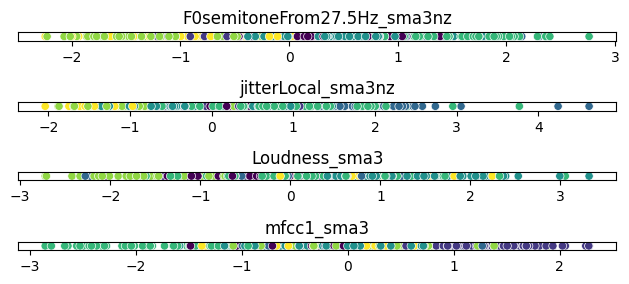

Cluster clustering2 - Feature F0semitoneFrom27.5Hz_sma3nz
Cluster clustering2 - Feature jitterLocal_sma3nz
Cluster clustering2 - Feature Loudness_sma3
Cluster clustering2 - Feature mfcc2_sma3


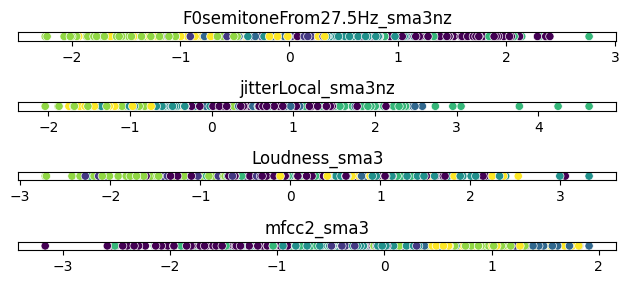

Cluster clustering3 - Feature F0semitoneFrom27.5Hz_sma3nz
Cluster clustering3 - Feature jitterLocal_sma3nz
Cluster clustering3 - Feature Loudness_sma3
Cluster clustering3 - Feature mfcc3_sma3


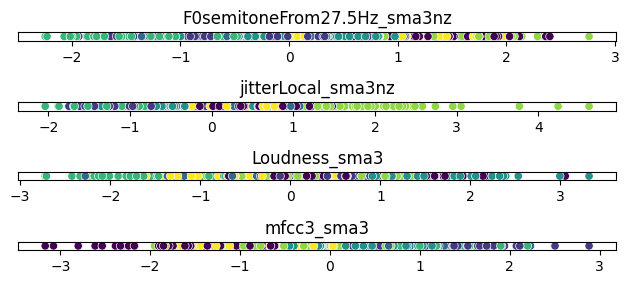

Cluster clustering4 - Feature F0semitoneFrom27.5Hz_sma3nz
Cluster clustering4 - Feature jitterLocal_sma3nz
Cluster clustering4 - Feature Loudness_sma3
Cluster clustering4 - Feature mfcc4_sma3


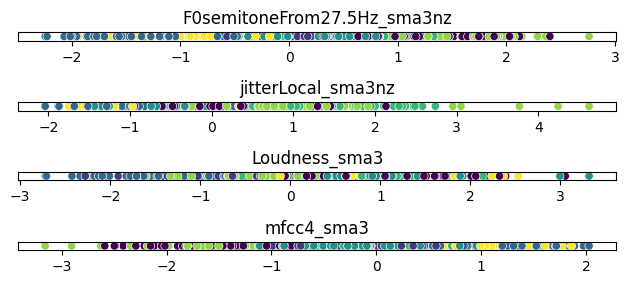

In [82]:
# Write your code here
# Standardize the features
scaler = StandardScaler()
final_df[selected_features] = scaler.fit_transform(final_df[selected_features])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=0)
featureset1 = ['F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'Loudness_sma3',
                    'mfcc1_sma3']
featureset2 = ['F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'Loudness_sma3',
                    'mfcc2_sma3']
featureset3 = ['F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'Loudness_sma3',
                    'mfcc3_sma3']
featureset4 = ['F0semitoneFrom27.5Hz_sma3nz', 'jitterLocal_sma3nz', 'Loudness_sma3',
                    'mfcc4_sma3']

final_df['clustering1'] = kmeans.fit_predict(final_df[featureset1])
final_df['clustering2'] = kmeans.fit_predict(final_df[featureset2])
final_df['clustering3'] = kmeans.fit_predict(final_df[featureset3])
final_df['clustering4'] = kmeans.fit_predict(final_df[featureset4])

clusterings = ['clustering1', 'clustering2', 'clustering3', 'clustering4']
for (clustering, feature_set) in zip(clusterings, [featureset1, featureset2, featureset3, featureset4]):
    for i, feature in enumerate(feature_set):
        print(f'Cluster {clustering} - Feature {feature}')
        plt.subplot(7, 1, i+1)
        sns.scatterplot(data=final_df, x=feature, y=0, hue=clustering, palette='viridis', legend=False)
        plt.title(feature)
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([])
    plt.tight_layout()
    plt.show()
    
    
# Plot the clusters
# plt.figure(figsize=(15, 5))
# for i, feature in enumerate(selected_features):
#     plt.subplot(7, 1, i+1)
#     sns.scatterplot(data=final_df, x=feature, y=0, hue='cluster', palette='viridis', legend=False)
#     plt.title(feature)
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.yticks([])
# plt.tight_layout()
# plt.show()



If your k-means clustering was correct, your plots should contain seven clusters. You may notice that your plots are hard to interpret as the clusters do not have any information on the emotion labels.

To understand how well each acoustic feature is in capturing a specific emotion, you can create a heatmap. A heatmap shows how many times each emotion appears in each cluster. The more often an emotion appears in a cluster, the better the acoustic feature is in capturing important information about that emotion. Your heat map should plot emotions on the x-axis, and cluster indices on the y-axis. To create this heat map, you can combine your cluster data with the `merged_df` dataframe that we provide you in part 1.2 of this lab. To plot the heat map, you can use `sns.heatmap`. 

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> Create and plot a heat map that represents the distribution of emotions per cluster. You should use the clusters you calculated in the previous code block.

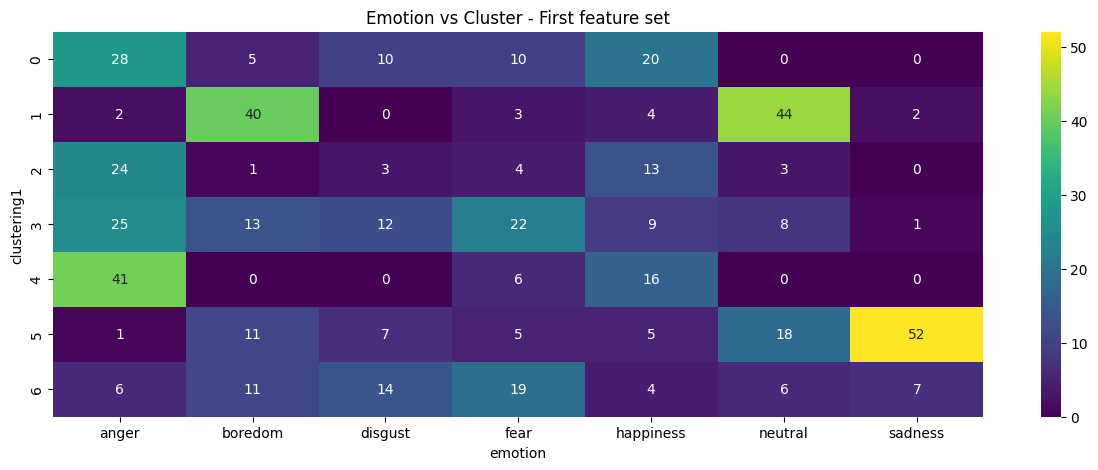

In [95]:
# Write your code here
# Create a pivot table
pivot_table = final_df.pivot_table(index='clustering1', columns='emotion', values='file', aggfunc='count', fill_value=0)

# Plot the heat map
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
plt.title('Emotion vs Cluster - First feature set')
plt.show()

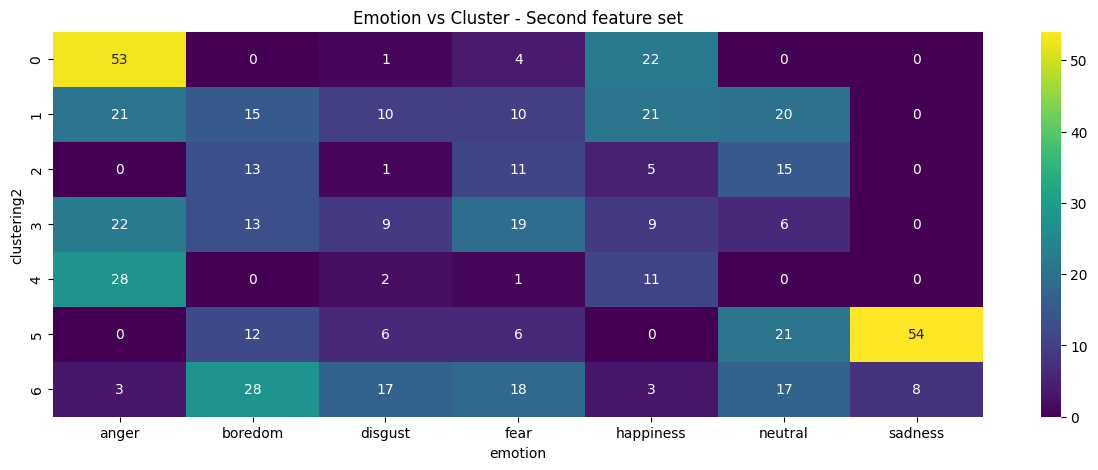

In [96]:
pivot_table = final_df.pivot_table(index='clustering2', columns='emotion', values='file', aggfunc='count', fill_value=0)

# Plot the heat map
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
plt.title('Emotion vs Cluster - Second feature set')
plt.show()

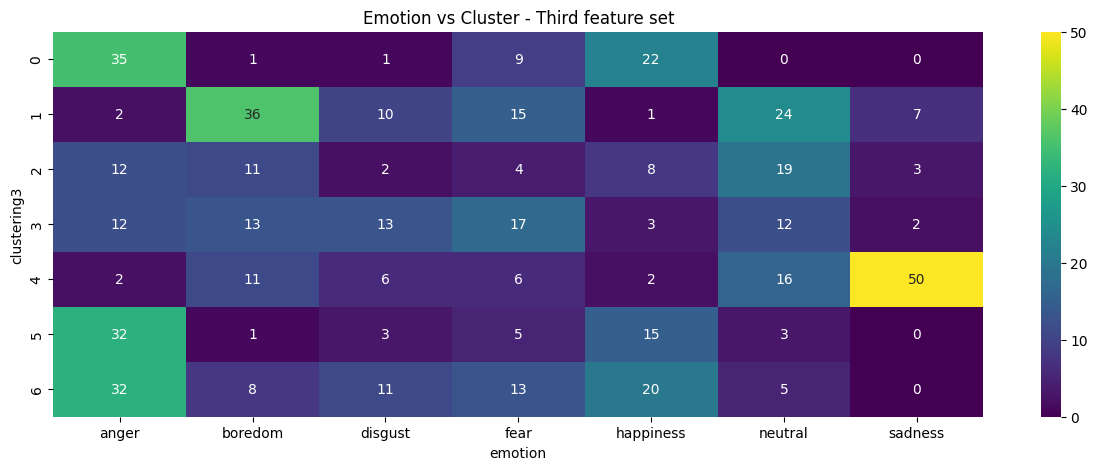

In [97]:
pivot_table = final_df.pivot_table(index='clustering3', columns='emotion', values='file', aggfunc='count', fill_value=0)

# Plot the heat map
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
plt.title('Emotion vs Cluster - Third feature set')
plt.show()

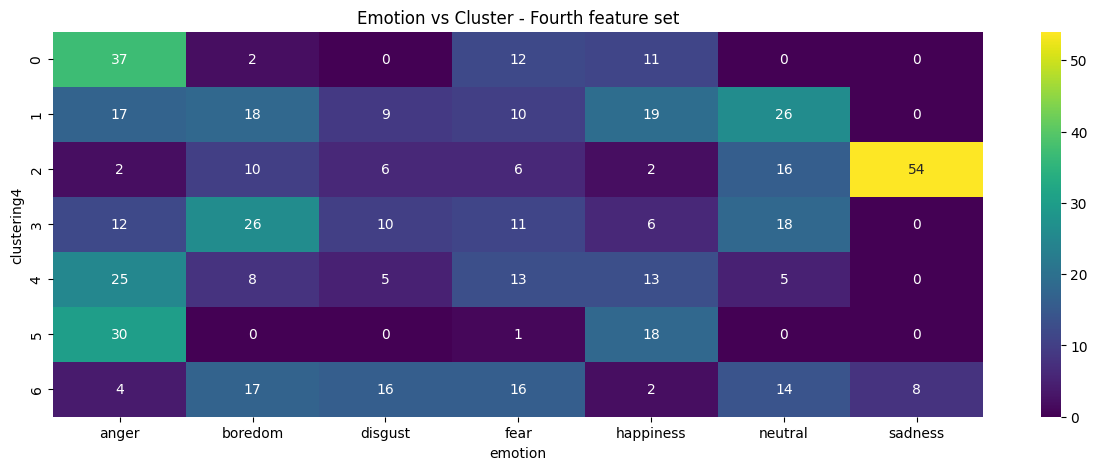

In [98]:
pivot_table = final_df.pivot_table(index='clustering4', columns='emotion', values='file', aggfunc='count', fill_value=0)

# Plot the heat map
plt.figure(figsize=(15, 5))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d')
plt.title('Emotion vs Cluster - Fourth feature set')
plt.show()

Another way of analyzing how emotions relate to your clusters would be to calculate the cluster purity score. The cluster purity tells you the degree to which the clusters contain a single class (emotion), and is given by the following formula: 
$$
\text{purity} = \frac{1}{N}\sum_{m\in M}\max_{d\in D}|m \cap d|
$$
where $M$ is the set of clusters, $D$ is the set of classes (emotions), and $N$ is the number of data points. **Use this formula to calculate the cluster purity for the clusters.**

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> In the code block below, calculate the purity scores for your clusters.

In [91]:
# Write your code here
# Calculate the cluster purity
cluster_purity = 0
for cluster in final_df['clustering1']:
    cluster_df = final_df[final_df['clustering1'] == cluster]
    cluster_emotions = cluster_df['emotion'].value_counts()
    cluster_purity += cluster_emotions.max()
cluster_purity /= len(final_df)
print(f'Clustering 1 Purity: {cluster_purity}')

cluster_purity = 0
for cluster in final_df['clustering2']:
    cluster_df = final_df[final_df['clustering2'] == cluster]
    cluster_emotions = cluster_df['emotion'].value_counts()
    cluster_purity += cluster_emotions.max()
cluster_purity /= len(final_df)
print(f'Clustering 2 Purity: {cluster_purity}')

cluster_purity = 0
for cluster in final_df['clustering3']:
    cluster_df = final_df[final_df['clustering3'] == cluster]
    cluster_emotions = cluster_df['emotion'].value_counts()
    cluster_purity += cluster_emotions.max()
cluster_purity /= len(final_df)
print(f'Clustering 3 Purity: {cluster_purity}')

cluster_purity = 0
for cluster in final_df['clustering4']:
    cluster_df = final_df[final_df['clustering4'] == cluster]
    cluster_emotions = cluster_df['emotion'].value_counts()
    cluster_purity += cluster_emotions.max()
cluster_purity /= len(final_df)
print(f'Clustering 4 Purity: {cluster_purity}')

Clustering 1 Purity: 34.822429906542055
Clustering 2 Purity: 33.31214953271028
Clustering 3 Purity: 32.76822429906542
Clustering 4 Purity: 31.241121495327103


**Take a second to reflect on the results of your clustering.**

<i style='color: #468fea; font-size: 20px;' class="fa fa-file-text" aria-hidden="true"></i> Which acoustic features result in a better clustering of the emotions and which in a worse clustering?

### 2.2 Clustering Vowels

Now that you have analyzed the effectiveness of the acoustic features to capture emotion in the speech files, you will do the same but for vowels. **First, create the same four acoustic features, loudness, pitch, jitter, and MFCCs, for the DAIS dataset. Next, use k-means clustering to cluster the acoustic features. Finally, calculate and analyze the cluster heat maps and cluster purity for your sets of clusters.** Make sure to answer the reflection questions at the end of this section.

<i style='color: #468fea; font-size: 20px;' class="fa fa-code" aria-hidden="true"></i> Calculate the acoustic features for the DAIS dataset, cluster the results, using five clusters, and calculate the cluster heat maps and purity.

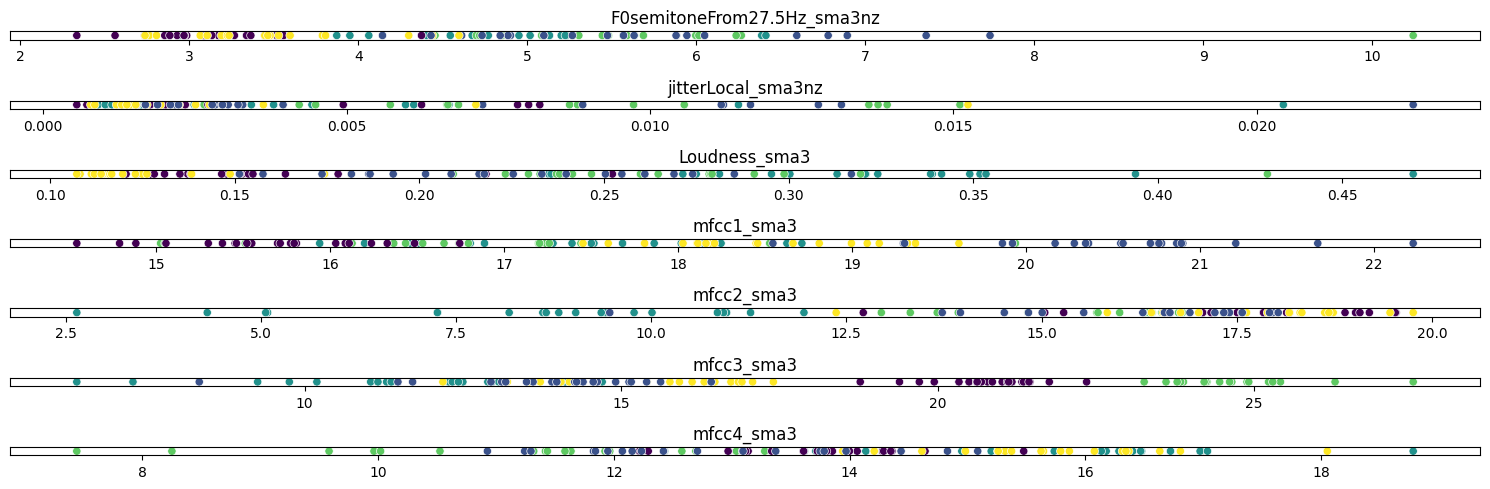

ValueError: could not convert string to float: 'sub-01_task-overt-aa_run-01_audio'

<Figure size 1500x500 with 0 Axes>

In [66]:
# Write your code here
# Load the DAIS dataset
path = 'DAIS/sub-01/audio'
fileList = os.listdir(path)

for i in range(0, len(fileList)):
    file = os.path.join(path, fileList[i])
    signal, sampling_rate = audiofile.read(
        file,
        duration=10,
        always_2d=True,
    )

    features = smile.process_signal(
        signal,
        sampling_rate
    )
    
    features = features[selected_features]
    features['file_name'] = fileList[i].split('/')[-1].split('.')[0]

    if i == 0:
        features_df = features.copy()
    else:
        features_df = pd.concat([features_df, features])

# combine frames from the same file
features_df = features_df.groupby('file_name').mean().reset_index()

# What are the ground truth vowels?
# merged_df['file'] = merged_df['file']
# label_df = merged_df[['file', 'transcription']]
# final_df = pd.merge(label_df, features_df, left_on='file', right_on='file_name')
# final_df.head()
final_df = features_df.copy()

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(final_df[selected_features])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)
final_df['cluster'] = kmeans.fit_predict(features)

# Plot the clusters
plt.figure(figsize=(15, 5))
for i, feature in enumerate(selected_features):
    plt.subplot(7, 1, i+1)
    sns.scatterplot(data=final_df, x=feature, y=0, hue='cluster', palette='viridis', legend=False)
    plt.title(feature)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])
plt.tight_layout()
plt.show()

# Create a pivot table
# pivot_table = final_df.pivot_table(index='cluster', columns='cluster', values='file_name', aggfunc='count', fill_value=0)

# Plot the heat map
plt.figure(figsize=(15, 5))
sns.heatmap(final_df, cmap='viridis', annot=True, fmt='d')
plt.title('Vowel vs Cluster')
plt.show()

# Calculate the cluster purity
cluster_purity = 0

# for cluster in final_df['cluster']:
#     cluster_df = final_df[final_df['cluster'] == cluster]
#     cluster_emotions = cluster_df['vowel'].value_counts()
#     cluster_purity += cluster_emotions.max()
# cluster_purity /= len(final_df)
# print(f'Cluster Purity: {cluster_purity}')

**Take a second to reflect on the results of your clustering.**

<i style='color: #468fea; font-size: 20px;' class="fa fa-file-text" aria-hidden="true"></i> Which acoustic features result in a better clustering of the vowels and which in a worse clustering? Are there differences in which acoustic features work better or worse on the two clustering tasks and why do you think that is?